# Monitoraggio Dati COVID-19 Italia

© Copyright 2020, Pietro Di Gangi

Raw data sources:
* COVID-19 data from Dipartimento della Protezione Civile: https://github.com/pcm-dpc/COVID-19
* Population data from  ISTAT (01/01/2019)

In [269]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [270]:
%run init.py

Current time: 2020-04-03 20:30:58.801823


In [271]:
#############################################
# Useful functions
#############################################
def sorted_set(regions, var):
    '''Ordina set rispetto alla variabile var'''
    df = data[data.region.isin(regions)][data.date==lastday].sort_values(var, ascending=False)
    sortedset = df.region.unique()
    return sortedset

def leglabels_style():
    '''Make legend labels colored'''
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
        
def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

In [289]:
#############################################
# Read data from github repo: https://github.com/pcm-dpc/COVID-19
# Dipartimento della Protezione Civile
#############################################
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
regioni = pd.read_csv(url)
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
prov = pd.read_csv(url)

#############################################
# Manipulate dataframes
#############################################
# Italia #################
ita = ita.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered',
})
ita['region'] = 'Italia'
ita['date'] = ita['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))


# Nord, Centro, Sud #################
nord = ['Lombardia', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Liguria', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Valle d\'Aosta', 'Veneto']
centro = ['Abruzzo', 'Lazio', 'Marche', 'Molise', 'Toscana', 'Umbria']
sud = ['Basilicata', 'Calabria', 'Campania', 'Puglia', 'Sardegna', 'Sicilia']
def zone(region):
    if region in nord:
        return 'Nord'
    elif region in centro:
        return 'Centro'
    elif region in sud:
        return 'Sud'
    else: print('Error: No zone assigned to region!')


# Regioni #################
regioni = regioni.rename(columns={
    'data': 'date',
    'totale_casi': 'cases',
    'deceduti' : 'deaths',
    'denominazione_regione' : 'region',
    'tamponi' : 'tests',
    'dimessi_guariti': 'recovered'
})
regioni['date'] = regioni['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
regioni['zone'] = regioni['region'].map(lambda location: zone(location))
regioni = regioni.sort_values(['region', 'date'])

# Aree (Nord, Centro, Sud) #################
aree = regioni.groupby(['zone', 'date'],as_index=False).sum()
aree['region'] = aree['zone']

# merge dataframes #################
data = ita.append([aree, regioni], ignore_index=True)

# Dati popolazione ISTAT 01/01/2019
population = {
    'Lombardia': 10.04e6,
    'Emilia-Romagna': 4.45e6,
    'Veneto': 4.91e6,
    'Piemonte': 4.38e6,
    'Marche': 1.53e6,
    'Toscana': 3.74e6,
    'Liguria': 1.56e6,
    'Lazio': 5.90e6,
    'Campania': 5.83e6,
    'Friuli Venezia Giulia': 1.22e6,
    'P.A. Trento': 541e3,
    'P.A. Bolzano': 531e3,
    'Puglia': 4.05e6,
    'Abruzzo': 1.32e6,
    'Sicilia': 4999891,
    'Umbria': 885e3,
    'Sardegna': 1.65e6,
    'Valle d\'Aosta': 126e3,
    'Calabria': 1.96e6,
    'Basilicata': 567e3,
    'Molise': 308e3,
    'Nord': 27758000,
    'Centro': 13683000,
    'Sud': 19056891,
    'Italia': 60497891
}
# add population information
for region in population.keys():
    data.at[data.region==region, 'population'] = population[region]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential data
for col in ['cases', 'recovered', 'deaths','tests','terapia_intensiva','totale_positivi','ricoverati_con_sintomi']:
    data['new_'+col] = data[col].diff()

data['new_terapia_intensiva_netta'] = data['new_terapia_intensiva'] + data['new_deaths'] + data['new_recovered']*data['terapia_intensiva'].shift(1)/data['ricoverati_con_sintomi'].shift(1)    

# add data per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered','tests','new_tests','terapia_intensiva','new_terapia_intensiva']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# add tassi d'incremento 
def delta(data, variables):
    '''Tasso di crescita mediato sugli ultimi 1,2,3,4 giorni'''
    for var in variables: 
        for dayspan in [1,2,3,4]:
            colname = var+'_delta'+str(dayspan)
            data[colname] = 0
            for i in np.arange(dayspan):
                data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
            data[colname] = data[colname]/dayspan    
    return data
data = delta(data, ['cases', 'deaths', 'recovered', 'tests'])

# cast some columns to int
data = data.replace(np.nan,0.0000000000)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population','tests','new_tests','terapia_intensiva','new_terapia_intensiva']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population','tests','new_tests','terapia_intensiva','new_terapia_intensiva']].astype(int)

# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'tests','new_tests','terapia_intensiva','new_terapia_intensiva','new_terapia_intensiva_netta','totale_ospedalizzati','ricoverati_con_sintomi','new_ricoverati_con_sintomi','isolamento_domiciliare','totale_positivi','new_totale_positivi',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'tests_per100k','new_tests_per100k','terapia_intensiva_per100k','new_terapia_intensiva_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
             'tests_delta1','tests_delta2','tests_delta3','tests_delta4',
            ]]

data.to_pickle('dataframes/mydata_dpc_ita.p')

# Tabella Dati Nazionali e Regionali

In [273]:
lastday = data.date.iat[-1]
print('Dati aggiornati a:', lastday)

summary = data[data.date==lastday].sort_values('cases', ascending=False)
summary = summary[['region','cases','new_cases','deaths','new_deaths','terapia_intensiva','cases_per100k','deaths_per100k']]
summary['cases_per100k'] = summary['cases_per100k'].map('{:.1f}'.format)
summary['deaths_per100k'] = summary['deaths_per100k'].map('{:.1f}'.format)
summary.head(30)

Dati aggiornati a: 2020-04-03 17:00:00


region   cases  new_cases  deaths  new_deaths  \
39                  Italia  119827       4585   14681         766   
119                   Nord   95043       3450   12896         614   
519              Lombardia   47520       1455    8311         351   
79                  Centro   16247        653    1242         104   
359         Emilia-Romagna   15932        599    1902          91   
719               Piemonte   10896        543    1043          60   
999                 Veneto   10464        353     572          40   
159                    Sud    8537        482     543          48   
879                Toscana    5499        226     290          22   
559                 Marche    4230        132     557          54   
479                Liguria    3965        183     519          31   
439                  Lazio    3600        167     199          14   
319               Campania    2677        221     181          14   
759                 Puglia    2182        105     164          20   
679            P.A. Trento    2109        106     204          17   
399  Friuli Venezia Giulia    1879         80     136           7   
839                Sicilia    1859         68     101           8   
199                Abruzzo    1563         66     146          13   
639           P.A. Bolzano    1559         80     139          10   
919                 Umbria    1179         51      39           1   
799               Sardegna     825         31      41           1   
279               Calabria     733         42      45           4   
959          Valle d'Aosta     719         51      70           7   
239             Basilicata     261         15      11           1   
599                 Molise     176         11      11           0   

     terapia_intensiva cases_per100k deaths_per100k  
39                4068         198.1           24.3  
119               2931         342.4           46.5  
519               1381         473.3           82.8  
79                 766         118.7            9.1  
359                364         358.0           42.7  
719                452         248.8           23.8  
999                335         213.1           11.6  
159                371          44.8            2.8  
879                288         147.0            7.8  
559                158         276.5           36.4  
479                173         254.2           33.3  
439                188          61.0            3.4  
319                115          45.9            3.1  
759                123          53.9            4.0  
679                 80         389.8           37.7  
399                 61         154.0           11.1  
839                 73          37.2            2.0  
199                 76         118.4           11.1  
639                 60         293.6           26.2  
919                 48         133.2            4.4  
799                 24          50.0            2.5  
279                 17          37.4            2.3  
959                 25         570.6           55.6  
239                 19          46.0            1.9  
599                  8          57.1            3.6

# 1D Diagnostic Plots
Andamento delle singole variabili relative ai casi COVID-19 tramite grafici 1D.

## Valori normalizzati su popolazione: dati cumulati
Totale casi COVID-19 confermati per 100000 abitanti in Italia (Nord, Centro e Sud)
* Bars: i contributi delle singole aree sono sovrapposti

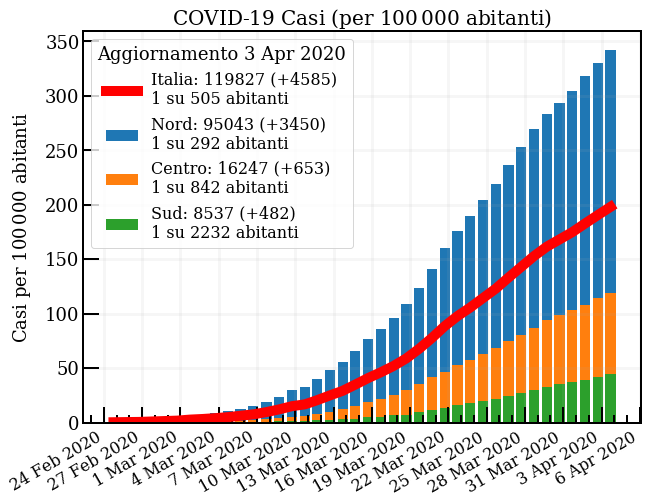

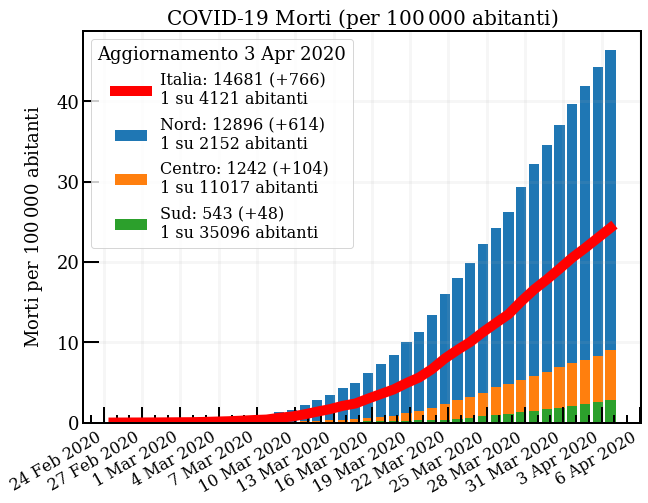

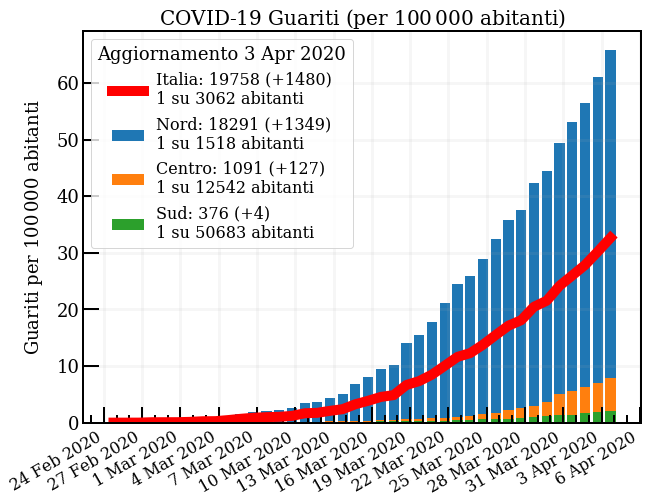

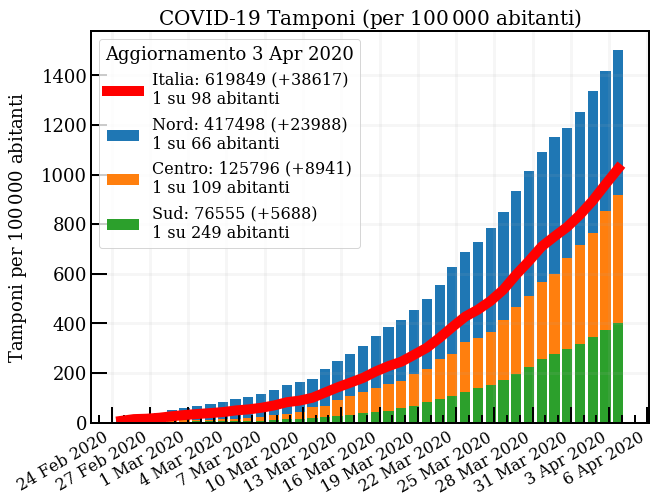

In [274]:
def cumulative_normalized(regions, var, title='', ylabel='y'):

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)
    
    # plot data
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (reg, tot, df['new_'+var].iat[-1])
        lb = lb + '\n1 su %.f abitanti' % (pop/tot)
        if reg=='Italia':
            ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')
        else:
            ax.bar(df.date, df[var]/pop*1e5, label=lb)

    # axes settings
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud','Italia']
cumulative_normalized(regions, 'cases', title='COVID-19 Casi (per 100$\,$000 abitanti)', ylabel='Casi per 100$\,$000 abitanti')
cumulative_normalized(regions, 'deaths', title='COVID-19 Morti (per 100$\,$000 abitanti)', ylabel='Morti per 100$\,$000 abitanti')
cumulative_normalized(regions, 'recovered', title='COVID-19 Guariti (per 100$\,$000 abitanti)', ylabel='Guariti per 100$\,$000 abitanti')
cumulative_normalized(regions, 'tests', title='COVID-19 Tamponi (per 100$\,$000 abitanti)', ylabel='Tamponi per 100$\,$000 abitanti')

## Valori normalizzati su popolazione: dati differenziali
Nuovi casi giornalieri COVID-19 per 100000 abitanti in Italia (Nord, Centro e Sud)

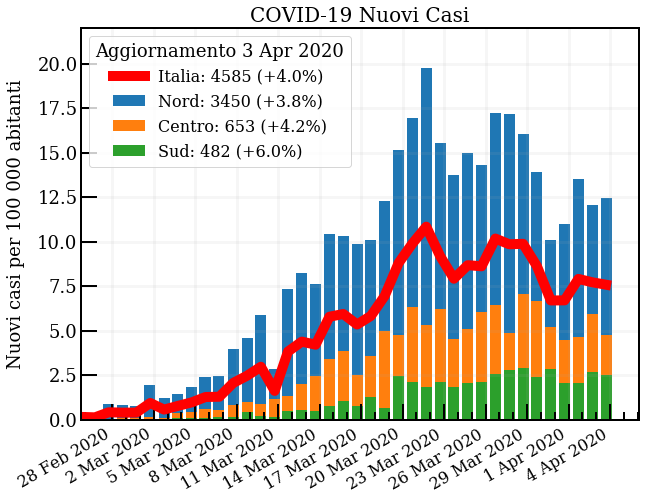

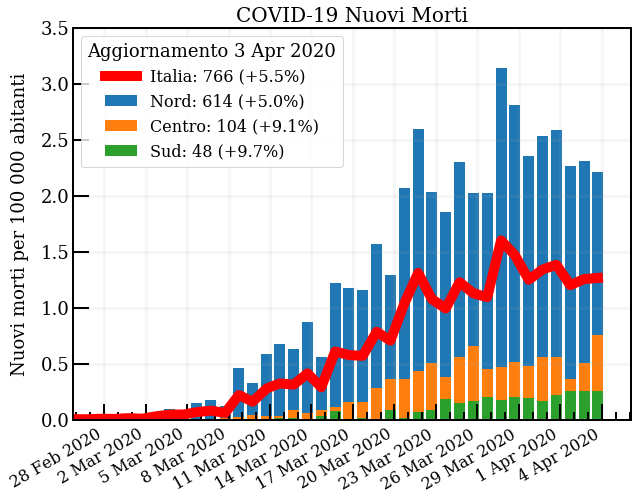

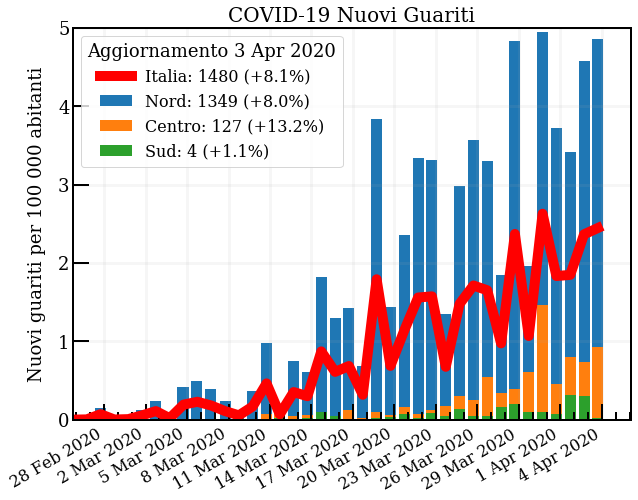

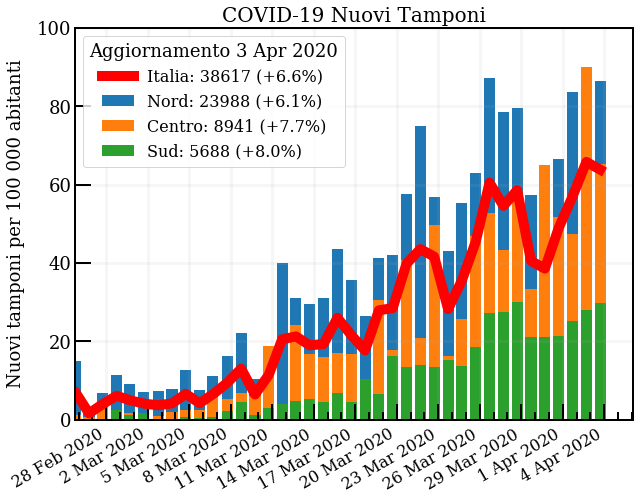

In [275]:
def differential_normalized(regions, var, title='', ylabel='y per 100 000 abitanti', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)
    
    # plot data
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]        
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (reg, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        if reg=='Italia':
            ax.plot(df.date, df[var]/pop*1e5, label=lb, color='r', lw=10, ls='-')
        else:
            ax.bar(df.date, df[var]/pop*1e5, label=lb)

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud','Italia']
differential_normalized(regions, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi per 100 000 abitanti',
                                  ymax = 22
                                 )

differential_normalized(regions, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti per 100 000 abitanti',
                                  ymax = 3.5
                                 )

differential_normalized(regions, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti per 100 000 abitanti',
                                  ymax = 5
                                 )

differential_normalized(regions, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi per 100 000 abitanti',
                                  ymax = 100
                                 )

## Valori assoluti: dati cumulati
Numero assoluto di casi COVID-19 confermati in Italia (Nord, Centro e Sud)
* Casi confermati
* Morti
* Guariti
* Tamponi effettuati

**Tipologia grafico**: Stacked bars - I contributi delle diverse aree sono impilati uno sopra l'altro

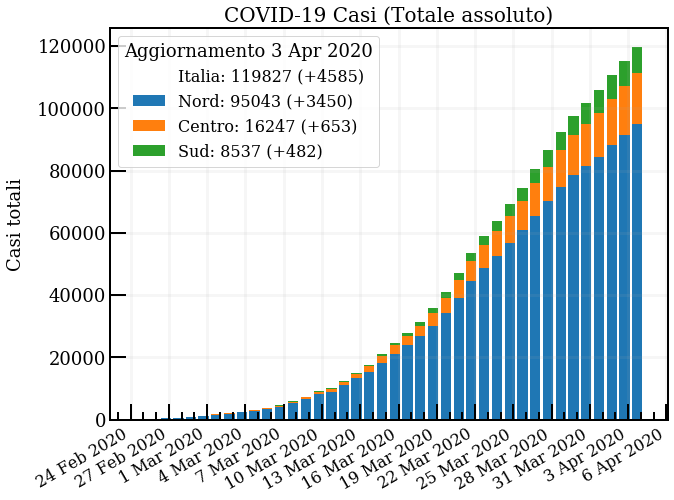

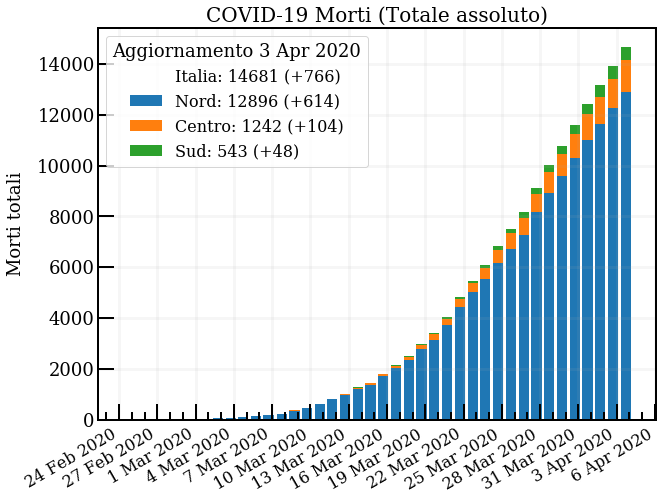

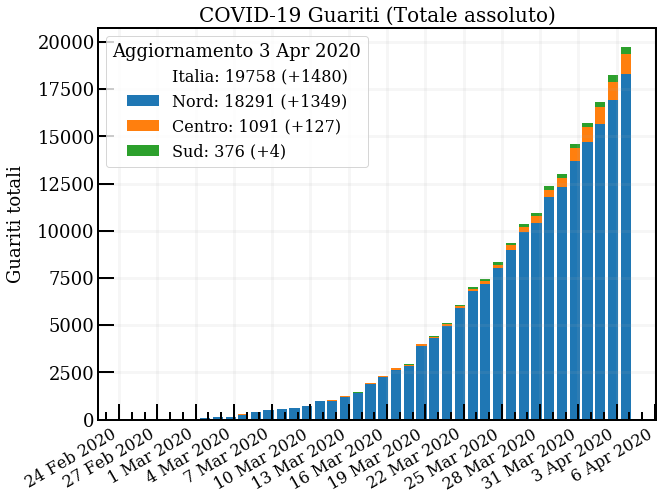

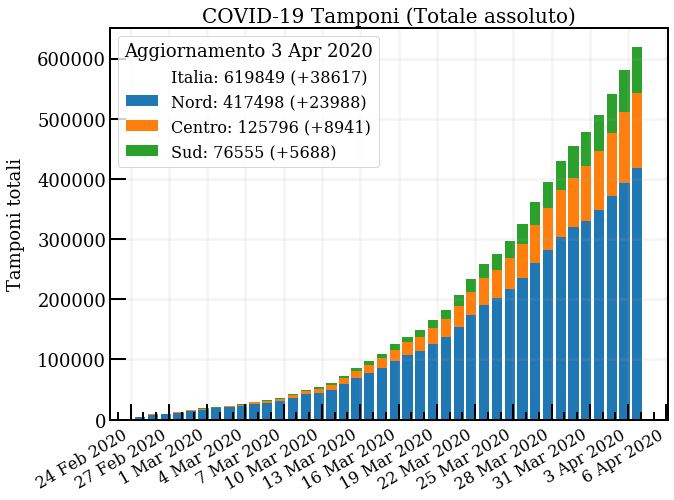

In [276]:
def cumulative(regions, colors, var, title='', ylabel='y'):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    regions = ['Nord', 'Centro', 'Sud']
    colors = ['tab:blue', "tab:orange","tab:green"]
    N = len(regions)

    df = data[data.region==regions[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        tot = df[var].iat[-1]
        lb = '%s: %d (+%.f)' % (reg, tot, df['new_'+var].iat[-1])

        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = data[data.region=='Italia']
    lb = 'Italia: %d (+%.f)' % (df[var].iat[-1], df['new_'+var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)
    
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
regions = ['Nord', 'Centro', 'Sud']
colors = ['tab:blue', "tab:orange","tab:green"]    
cumulative(regions, colors, 'cases', title='COVID-19 Casi (Totale assoluto)', ylabel='Casi totali')
cumulative(regions, colors, 'deaths', title='COVID-19 Morti (Totale assoluto)', ylabel='Morti totali')
cumulative(regions, colors, 'recovered', title='COVID-19 Guariti (Totale assoluto)', ylabel='Guariti totali')
cumulative(regions, colors, 'tests', title='COVID-19 Tamponi (Totale assoluto)', ylabel='Tamponi totali')

## Valori assoluti: dati differenziali
Variazione assoluta giornaliera di casi COVID-19 in Italia (Nord, Centro e Sud).
* Stacked bars: i contributi delle diverse aree sono impilati uno sopra l'altro

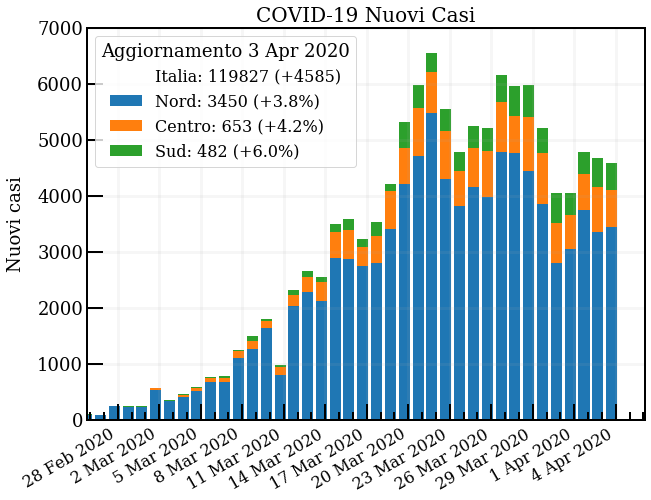

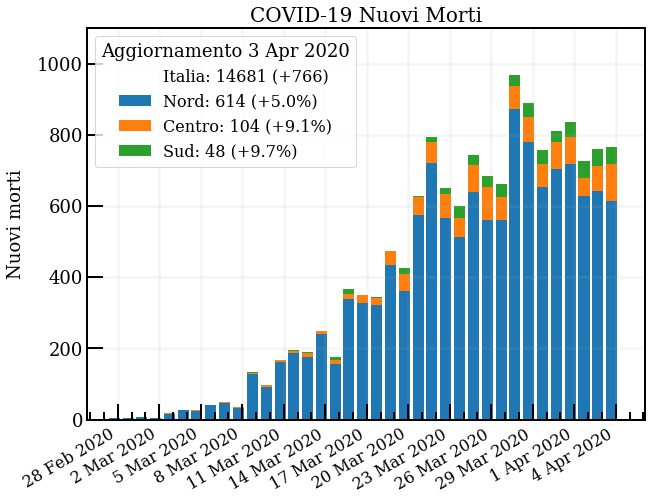

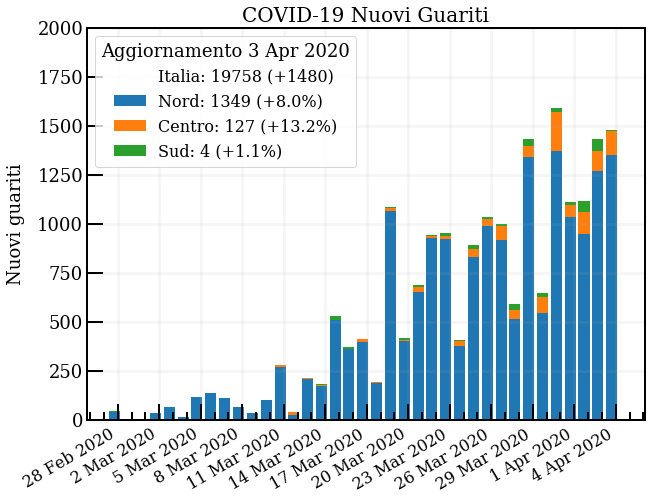

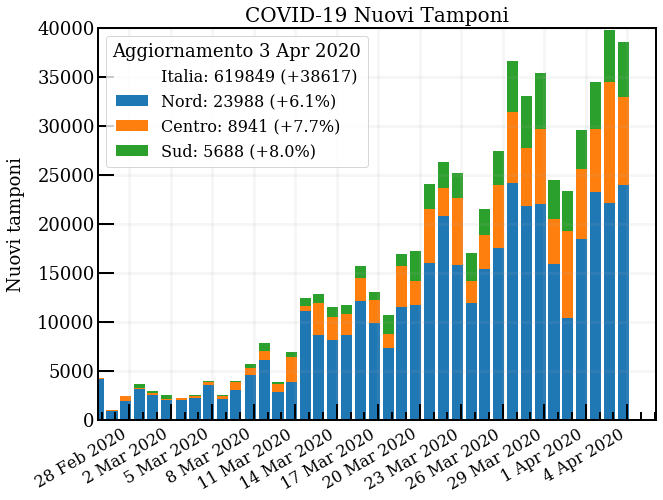

In [277]:
def differential(regions, var, title='', ylabel='y', ymax=100):
    cumvar = var.replace("new_", "")

    # figure
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # selected sets
    N = len(regions)    
    
    # plot data
    df = data[data.region==regions[0]]
    margin_bottom = np.zeros(len(df['date'].drop_duplicates()))
    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        tot = df[var].iat[-1]
        lb = '%s: %.f (+%.1f%s)' % (reg, tot, df[cumvar+'_delta1'].iat[-1]*100, '%')
        
        values = list(df[var])
        ax.bar(df.date, df[var], bottom=margin_bottom, label=lb)
        margin_bottom += values
    
    df = data[data.region=='Italia']
    lb = 'Italia: %d (+%.f)' % (df[cumvar].iat[-1], df[var].iat[-1])
    ax.plot(df.date, df[var], label=lb, color='r', lw=5, ls='-', alpha=0)

    # axes settings
    ax.set_xlim(left = df.date.iat[1])
    ax.set_ylim(0,ymax)
    plt.ylabel(ylabel)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    
regions = ['Nord', 'Centro', 'Sud']    
differential(regions, 'new_cases', 
                                  title = 'COVID-19 Nuovi Casi', 
                                  ylabel = 'Nuovi casi',
                                  ymax = 7000
                                 )

differential(regions, 'new_deaths', 
                                  title = 'COVID-19 Nuovi Morti', 
                                  ylabel = 'Nuovi morti',
                                  ymax = 1100
                                 )

differential(regions, 'new_recovered', 
                                  title = 'COVID-19 Nuovi Guariti', 
                                  ylabel = 'Nuovi guariti',
                                  ymax = 2000
                                 )

differential(regions, 'new_tests', 
                                  title = 'COVID-19 Nuovi Tamponi', 
                                  ylabel = 'Nuovi tamponi',
                                  ymax = 40000
                                 )

# Overview COVID-19
Dati cumulati (valore accumulato fino ad oggi):
* Tamponi effettuati
* Casi confermati
* Dimessi guariti
* Morti

Dati attuali (valore registrato oggi):
* Attualmente positivi
* Ospedalizzati
* Ricoverati con sintomi
* In isolamento domiciliare
* In terapia intensiva

## Italia
Andamento e valori complessivi in Italia (Nord, Centro, Sud)

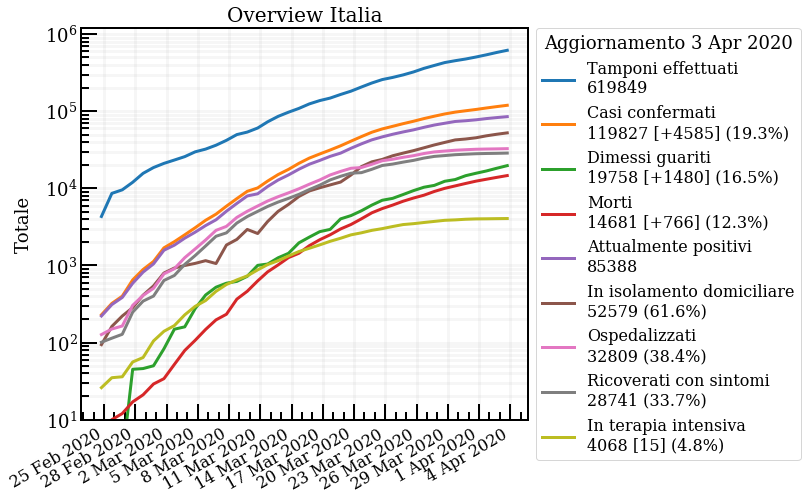

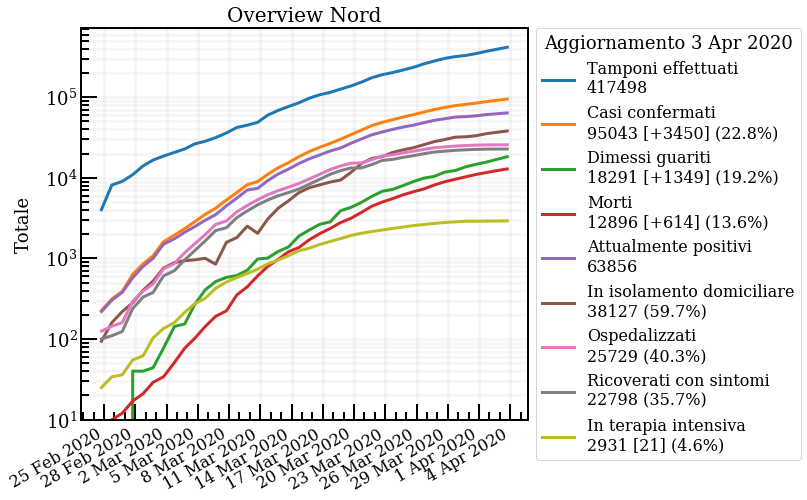

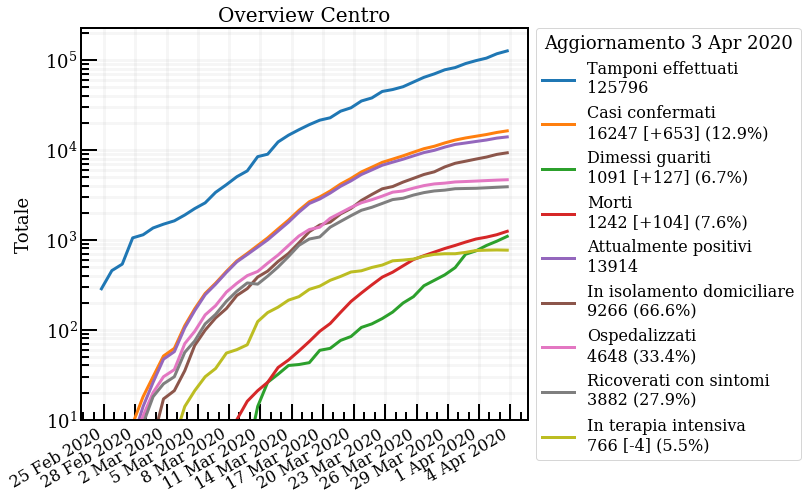

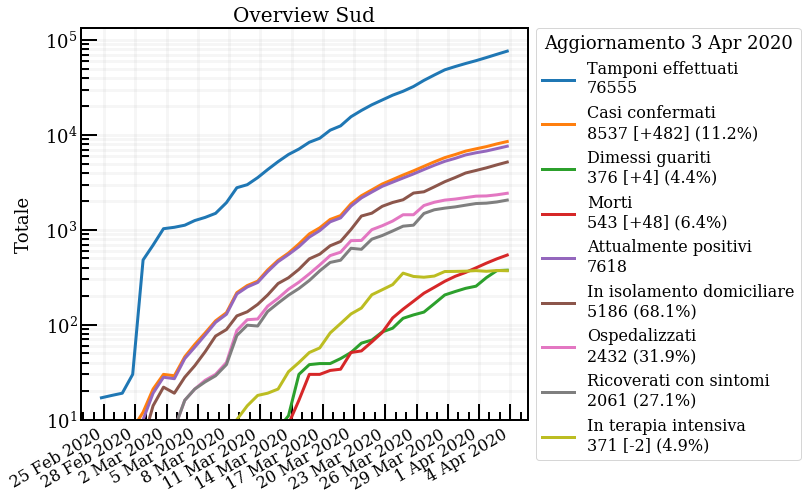

In [278]:
def overview(region, title=''):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    # dati cumulati
    ax.plot(df.date, df.tests, label='Tamponi effettuati\n%d' % df.tests.iat[-1])
    lb = 'Casi confermati\n%d [+%.f]' % (df.cases.iat[-1], df.new_cases.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.cases.iat[-1]/df.tests.iat[-1]*100, '%')
    ax.plot(df.date, df.cases, label=lb)
    lb = 'Dimessi guariti\n%d [+%.f]' % (df.recovered.iat[-1], df.new_recovered.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.recovered.iat[-1]/df.cases.iat[-1]*100, '%')
    ax.plot(df.date, df.recovered, label=lb)
    lb = 'Morti\n%d [+%.f]' % (df.deaths.iat[-1], df.new_deaths.iat[-1])
    lb = lb + ' (%.1f%s)' % (df.deaths.iat[-1]/df.cases.iat[-1]*100, '%')
    ax.plot(df.date, df.deaths, label=lb)
    
    # dati attuali
    ax.plot(df.date, df.totale_positivi, label='Attualmente positivi\n%d' % df.totale_positivi.iat[-1])
    tot = df.isolamento_domiciliare.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.isolamento_domiciliare, label='In isolamento domiciliare\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.totale_ospedalizzati.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.totale_ospedalizzati, label='Ospedalizzati\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.ricoverati_con_sintomi.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    ax.plot(df.date, df.ricoverati_con_sintomi, label='Ricoverati con sintomi\n%d (%.1f%s)' % (tot, pc*100, '%'))
    tot = df.terapia_intensiva.iat[-1]
    pc = tot/df.totale_positivi.iat[-1]
    new = df.new_terapia_intensiva.iat[-1]
    ax.plot(df.date, df.terapia_intensiva, label='In terapia intensiva\n%d [%.f] (%.1f%s)' % (tot, new, pc*100, '%'))
    
    plt.ylabel('Totale')
    plt.yscale('log')
    ax.set_ylim(bottom=10)
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='major')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left',fontsize=16, bbox_to_anchor=(1.,1.02), title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

regions = ['Nord', 'Centro', 'Sud']
overview('Italia', 'Overview Italia')
for area in ['Nord', 'Centro', 'Sud']:
    overview(area, 'Overview '+area)

## Evoluzione giornaliera della situazione ospedaliera
Aumento giornaliero di:
* Casi confermati
* Morti
* Dimessi guariti
* Nuovi ricoveri in terapia intensiva (TI) *

Variazione giornaliera di:
* Persone attualmente positive
* Persone ricoverate in ospedale
* Persone ricoverate in terapia intensiva

(*) I nuovi ingressi giornalieri in terapia intensiva sono stimati sulla base della variazione di posti di TI attualmente occupati, morti e guariti. In questo modo si tiene conto dei posti di TI liberati ogni giorno, stimati sotto le seguenti assunzioni:
* Posto di TI liberato per morte - I morti di oggi si trovavano in terapia intensiva il giorno precedente
* Posto di TI liberato per guarigione - Fra i dimessi guariti di oggi, una frazione uguale a ricoveri_terapia_intensiva/ricoveri (riscontrata il giorno precedente) era ricoverata in terapia intensiva


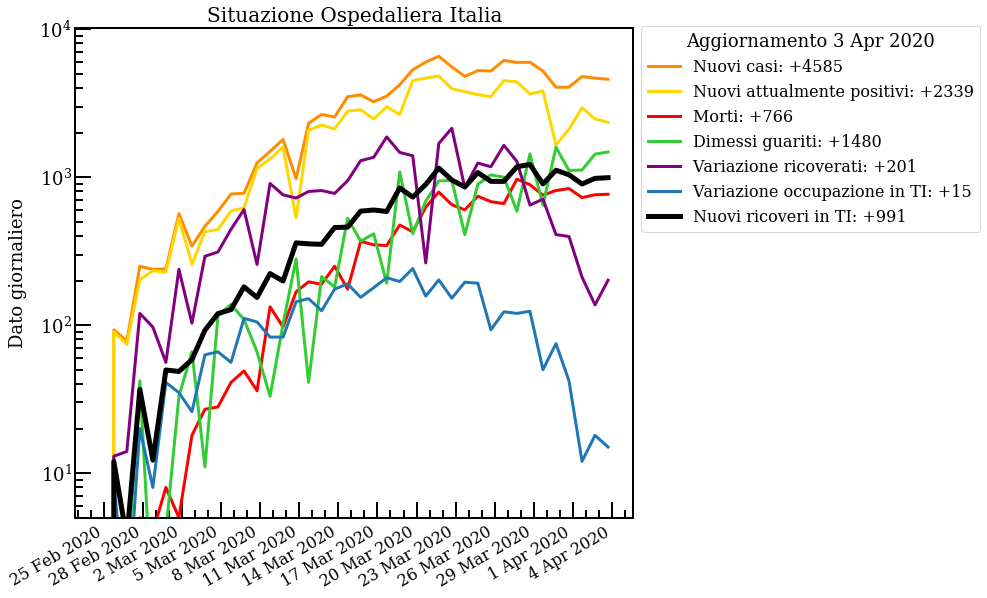

In [279]:
def icu(region, title=''):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
   
    df = data[data.region==region]
    
    ax.plot(df.date, df.new_cases, color='darkorange', label='Nuovi casi: +%d' % df.new_cases.iat[-1])
    ax.plot(df.date, df.new_totale_positivi, color='gold', label='Nuovi attualmente positivi: +%d' % df.new_totale_positivi.iat[-1])
    ax.plot(df.date, df.new_deaths, color='r', label='Morti: +%d' % df.new_deaths.iat[-1])
    ax.plot(df.date, df.new_recovered, color='limegreen', label='Dimessi guariti: +%d' % df.new_recovered.iat[-1])
    ax.plot(df.date, df.new_ricoverati_con_sintomi, color='purple', label='Variazione ricoverati: +%d' % df.new_ricoverati_con_sintomi.iat[-1])
    if df.new_terapia_intensiva.iat[-1]<0: sign='-'
    else: sign='+'
    ax.plot(df.date, df.new_terapia_intensiva, color='tab:blue', label='Variazione occupazione in TI: %s%d' % (sign,df.new_terapia_intensiva.iat[-1]))
    ax.plot(df.date, df.new_terapia_intensiva_netta, lw=5, ls='-', color='k', label='Nuovi ricoveri in TI: +%d' % df.new_terapia_intensiva_netta.iat[-1])

    
    plt.ylabel('Dato giornaliero')
    plt.yscale('log')
    ax.set_ylim(bottom=5)
    ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-d %b %Y'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()
    
    #legend
    leg = plt.legend(loc='upper left', bbox_to_anchor=(1,1.02), fontsize=16, title='Aggiornamento %s' % lastday.strftime('%-d %b %Y')) 
    plt.title(title, fontsize=20)
    
    plt.show()
    

icu('Italia', 'Situazione Ospedaliera Italia')

## Regioni
Andamento e valori complessivi nelle singole regioni

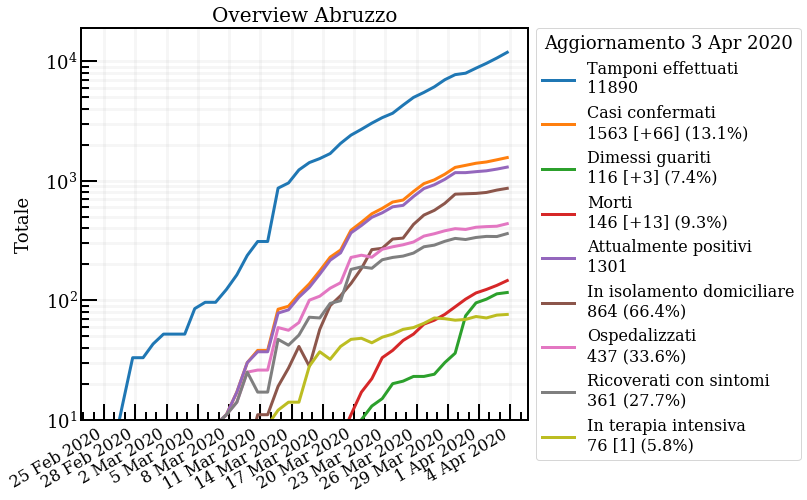

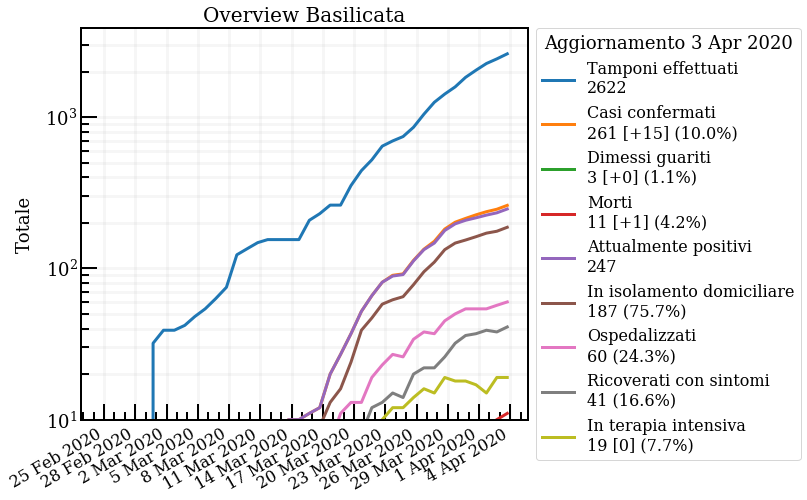

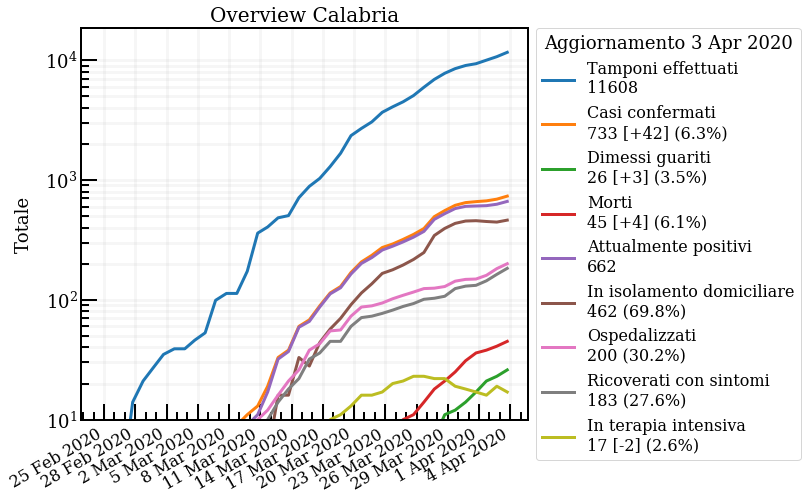

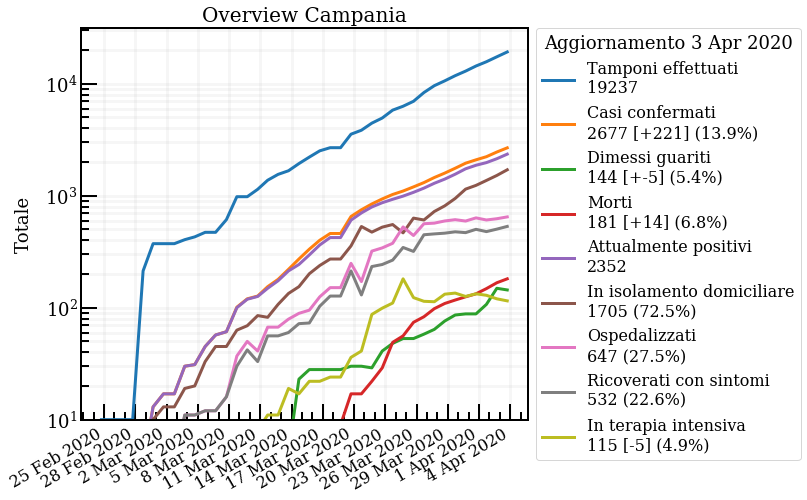

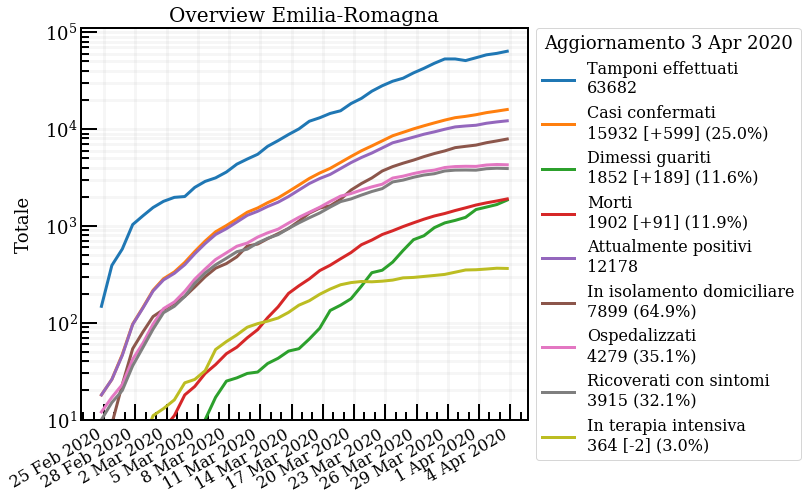

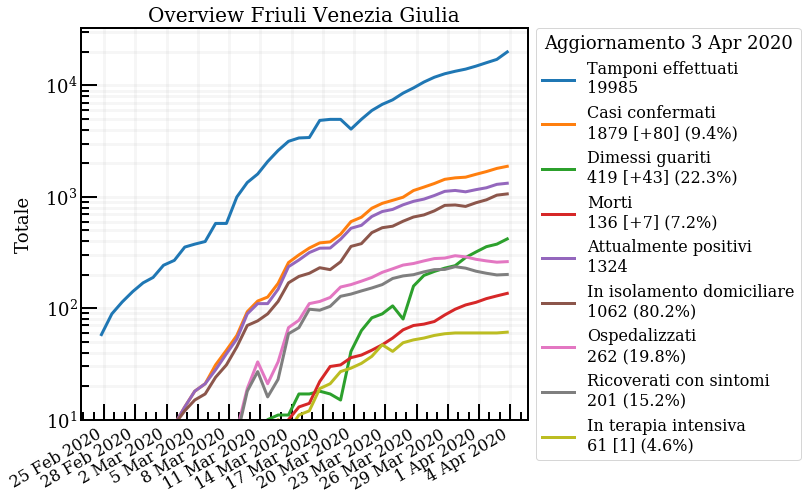

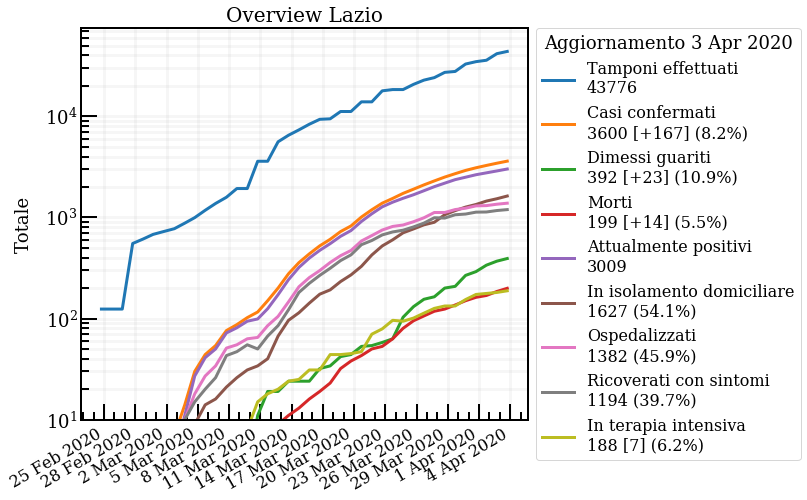

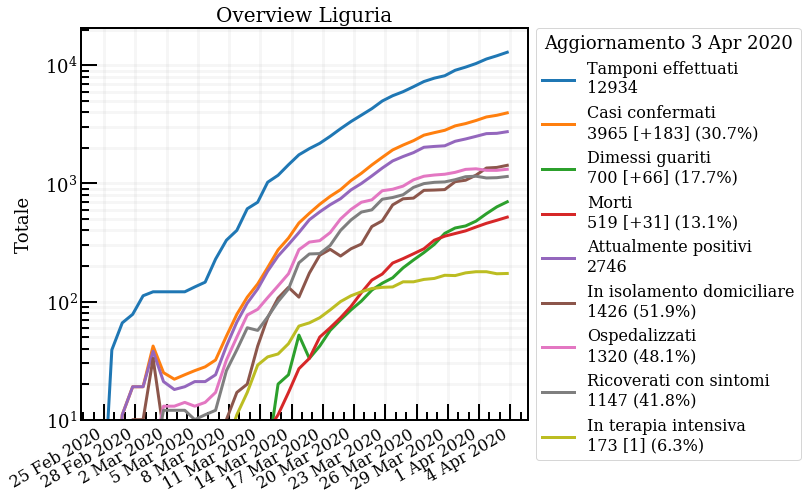

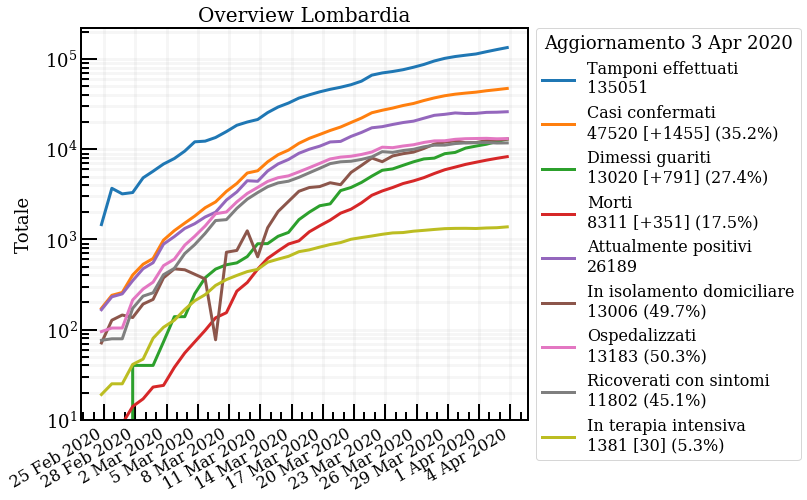

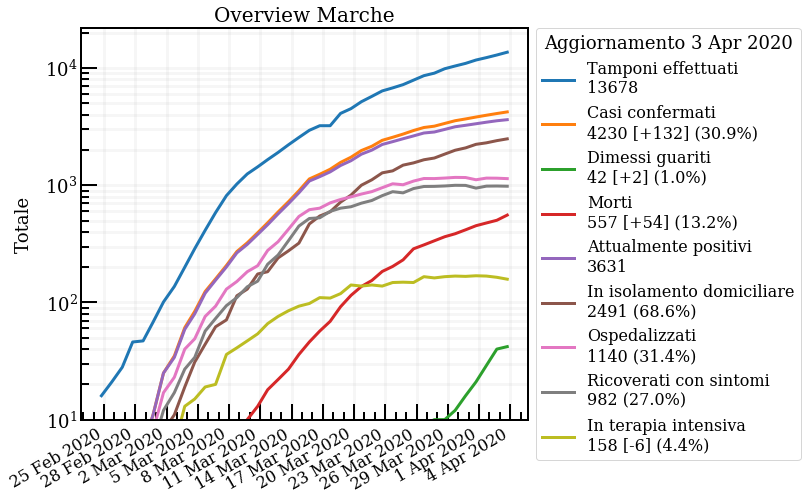

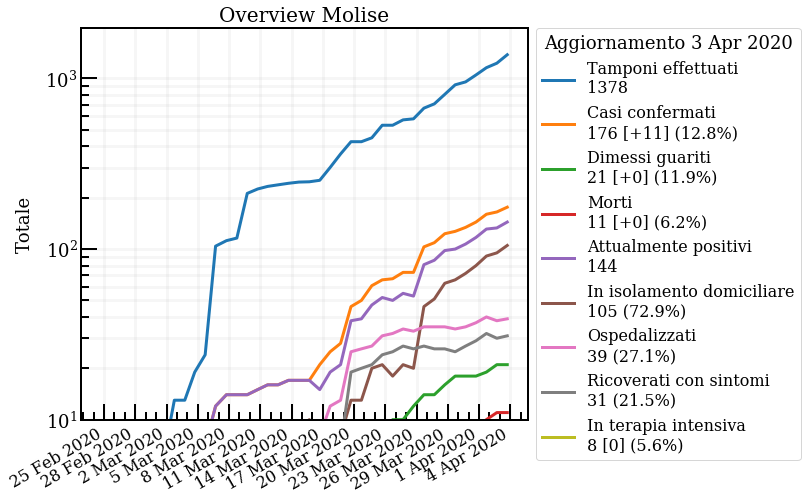

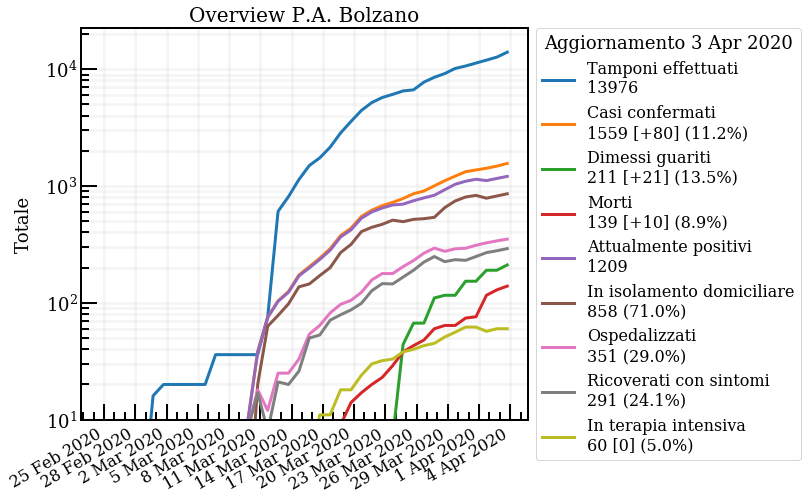

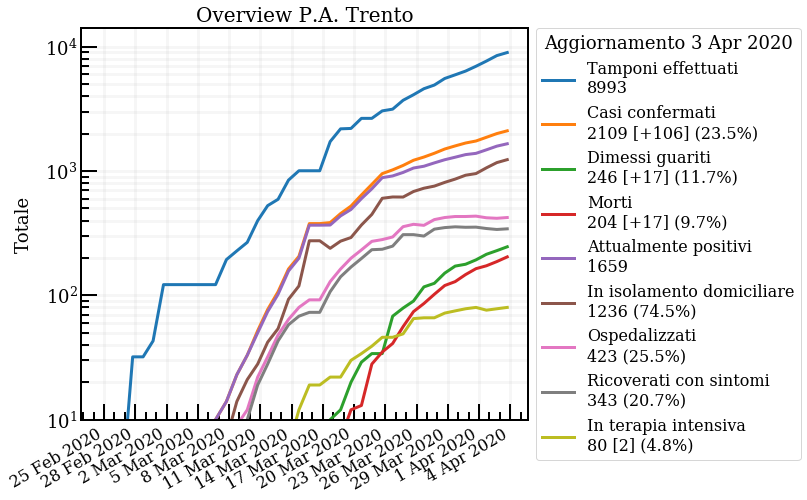

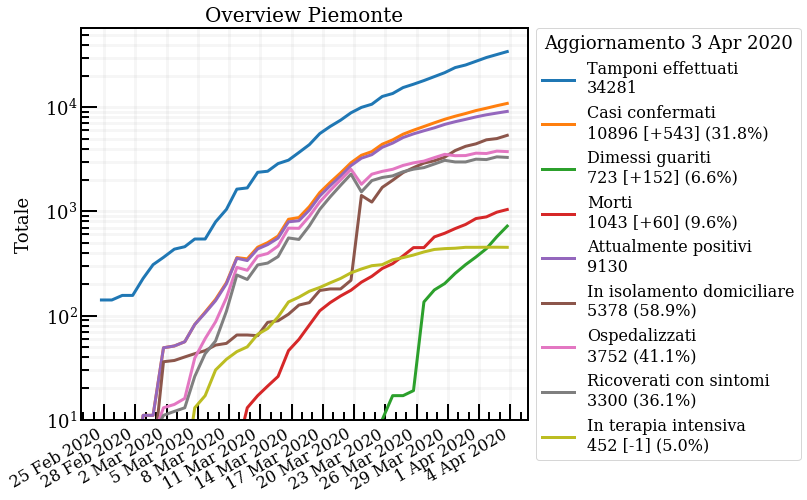

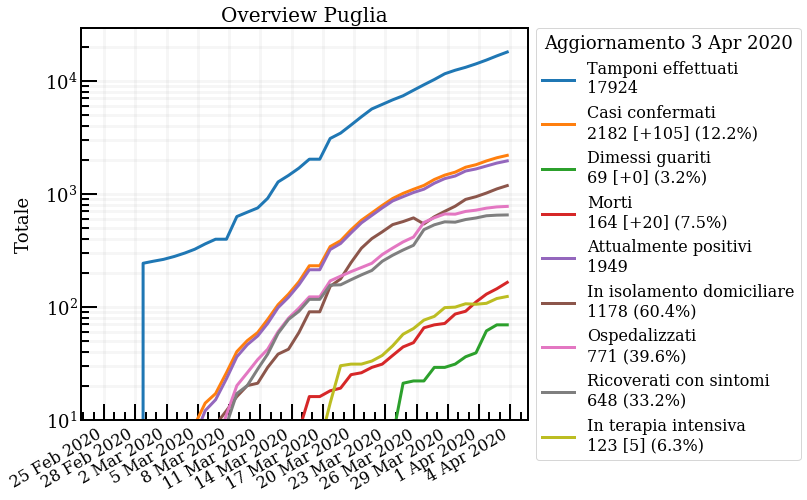

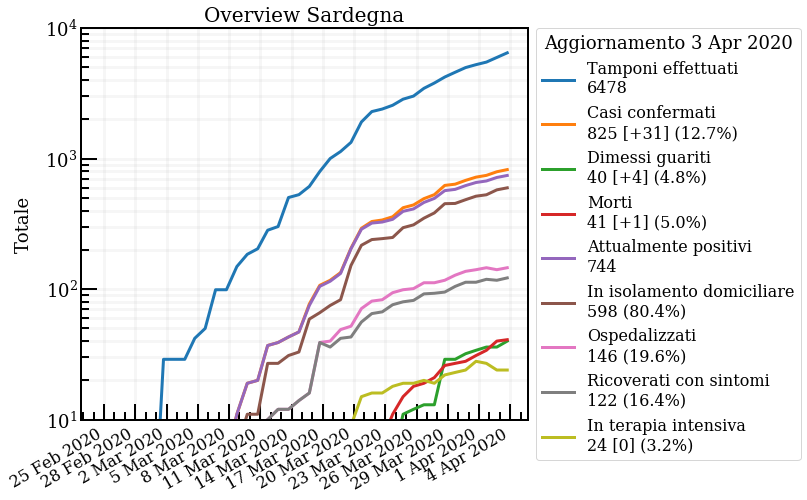

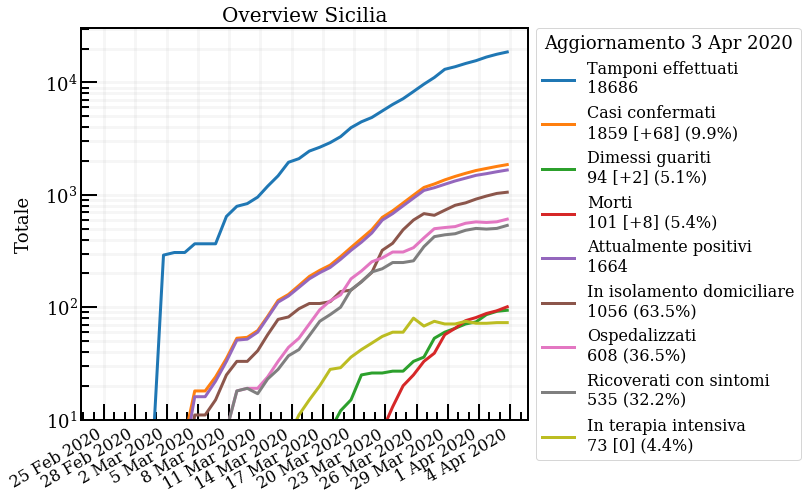

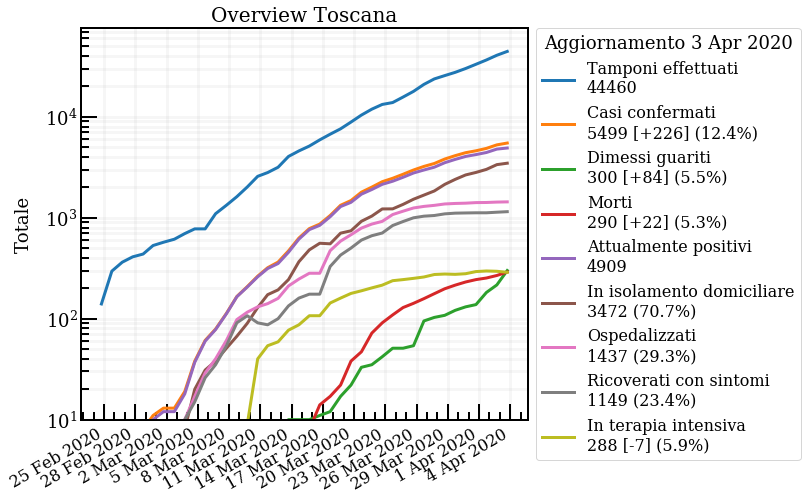

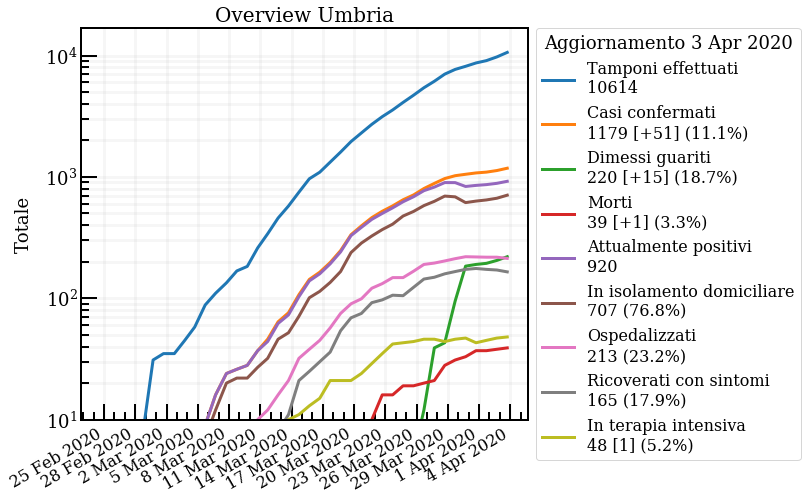

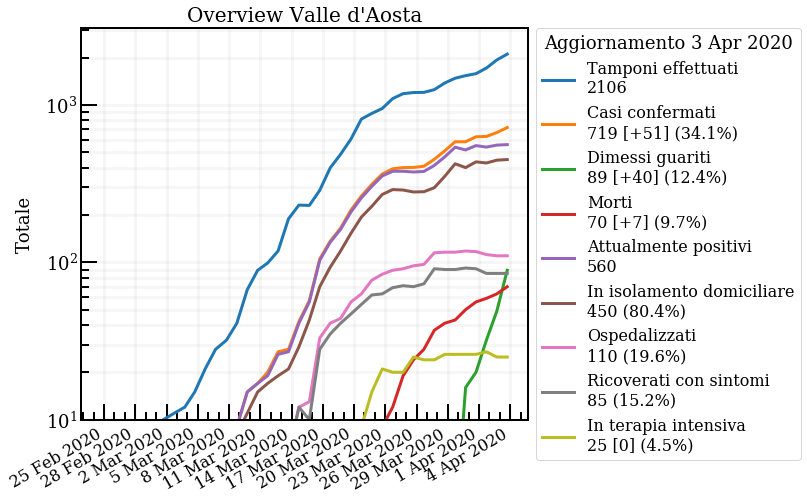

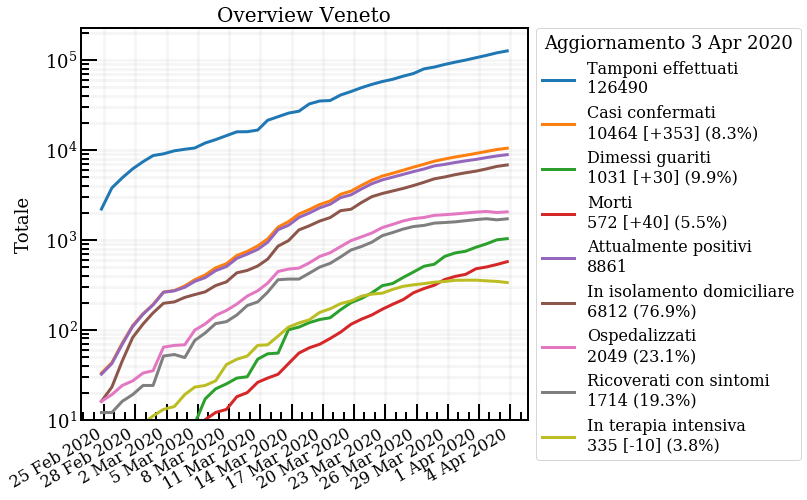

In [280]:
for regione in regioni['region'].unique():
    overview(regione, 'Overview '+regione)

# 2D Trail Plots
Tracciamento dell'evoluzione dei dati (due variabili) tramite scie di punti in grafici 2D.
L'evoluzione dei singoli parametri e' proiettata nei pannelli inferiore e sinistro.

**Come interpretare il grafico:**
* Punti piu' trasparenti corrispondono a giorni precedenti
* La coppia di valori alla data attuale e' mostrata da un punto colorato (zero trasparenza)
* Una maggiore distanza fra i punti (lungo uno degli assi o entrambi) indica una maggiore rapidita' di evoluzione del dato su base giornaliera.
* I valori numerici indicano il valore assoluto raggiunto e l'aumento giornaliero (tra parentesi).


## Casi confermati - Morti

In [281]:
def guideline(ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,xmax), (0,m*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m*5)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(regions, ndays, varx, vary, xlabel, ylabel, xlim, ylim, guidelines, gl_label):
    sorted_df = data[data.region.isin(regions)][data.date==lastday].sort_values(varx)
    regions = sorted_df.region.unique()

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(2, 3, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)

    # axes
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    y_ax.set_ylabel(ylabel+' per 100 000 abitanti')
    x_ax.set_xlabel(xlabel+' per 100 000 abitanti')

    # mortality guidelines
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label=gl_label)

    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100
    #dummy points
    #x_ax.scatter(0,'',label='', color='w')
    y_ax.scatter('',0,label='', color='w')

    cmap = plt.get_cmap('nipy_spectral')
    for i,reg in enumerate(regions):
        color = cmap(i/len(regions))
        df = data[data.region==reg]
        pop = df['population'].iat[0]
        #ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label='', color=color, marker=mk, s=ms)
        #x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        for day in list(reversed(days)):
            x = df[varx].iat[-day]/pop*1e5 # total value 'day' ago
            y = df[vary].iat[-day]/pop*1e5
            alpha = 1./day
            ax.scatter(x,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,reg,label='', color=color, marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(reg,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        x_ax.text(x+0.03*xlim[1], reg, '%d (+%d)' % (df[varx].iat[-1], df['new_'+varx].iat[-1]), ha='left', va='center', fontsize=12)
        y_ax.text(reg, y+0.03*ylim[1], '%d (+%d)' % (df[vary].iat[-1], df['new_'+vary].iat[-1]), ha='center', va='bottom', fontsize=10, rotation=90)

    ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

    #legend
    leg = ax.legend(loc='upper left', frameon=True, ncol=1, 
                     title='COVID-19 | Ultimi %d giorni\n(Aggiornato %s)' % (ndays, lastday.strftime('%-d %b %Y')))
    #leglabels_style()

    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
No handles with labels found to put in legend.


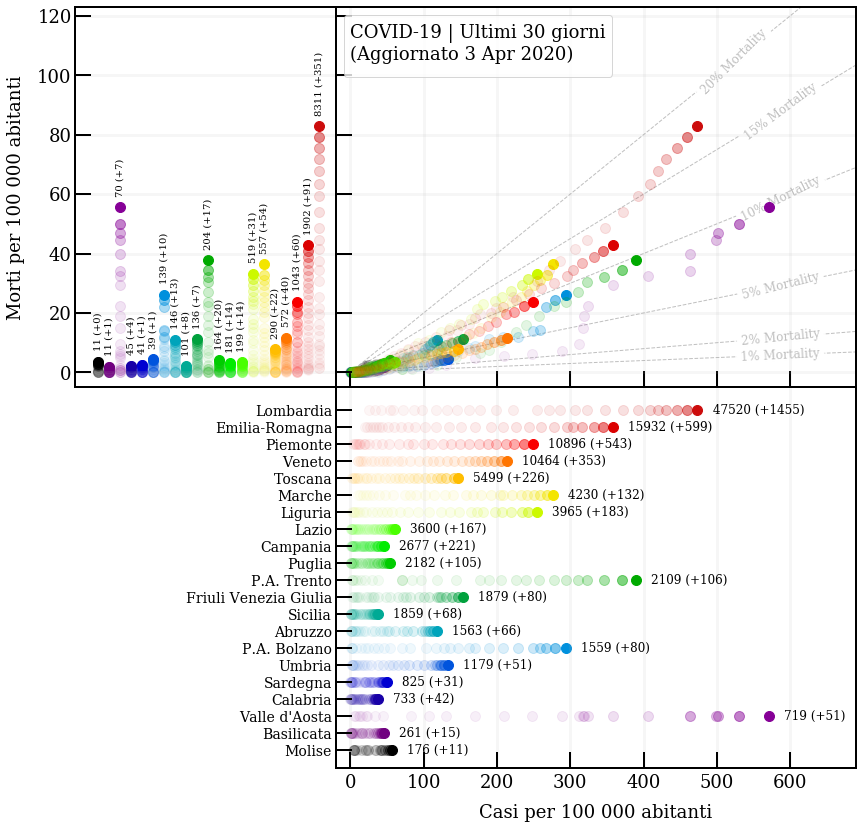

In [282]:
# Casi vs Morti
trailplot(regions=regioni.region.unique(), ndays=30,
          varx='cases', vary='deaths', xlabel='Casi', ylabel='Morti',
          xlim=(-20,690), ylim=(-5,123), guidelines=[0.2,0.15,0.1,0.05,0.02,0.01], gl_label='Mortality',
         )

## Tamponi effettuati - Casi di positivita' 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
No handles with labels found to put in legend.


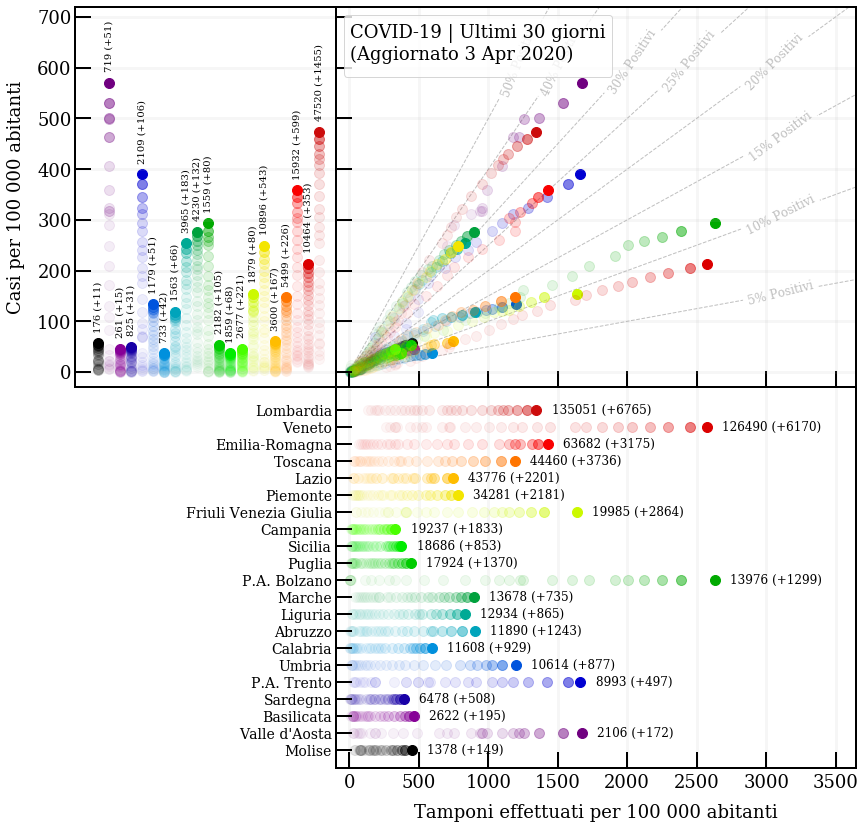

In [283]:
# Casi vs Terapia intensiva
trailplot(regions=regioni.region.unique(), ndays=30,
          varx='tests', vary='cases', ylabel='Casi', xlabel='Tamponi effettuati',
          xlim=(-100,3650), ylim=(-30,720), guidelines=[0.5,0.4,0.3,0.25,0.2,0.15,0.1,0.05], gl_label='Positivi',
         )

## Casi positivi - Casi in terapia intensiva
Evoluzione dei casi positivi (totale) e ricoveri in terapia intensiva (attuale) per regione.

**Effetto della neutralizzazione del virus:**
* Nessun avanzamento lungo l'asse dei casi totali
* Caduta dei punti verso lo zero dell'asse dei casi in terapia intensiva

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


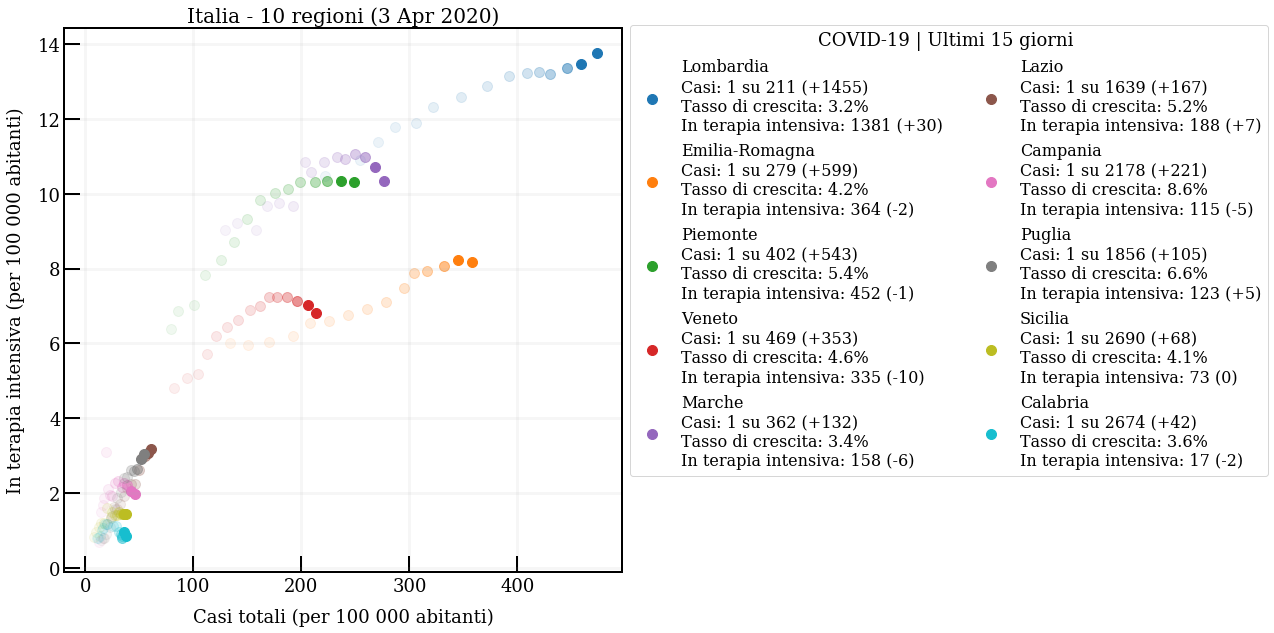

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


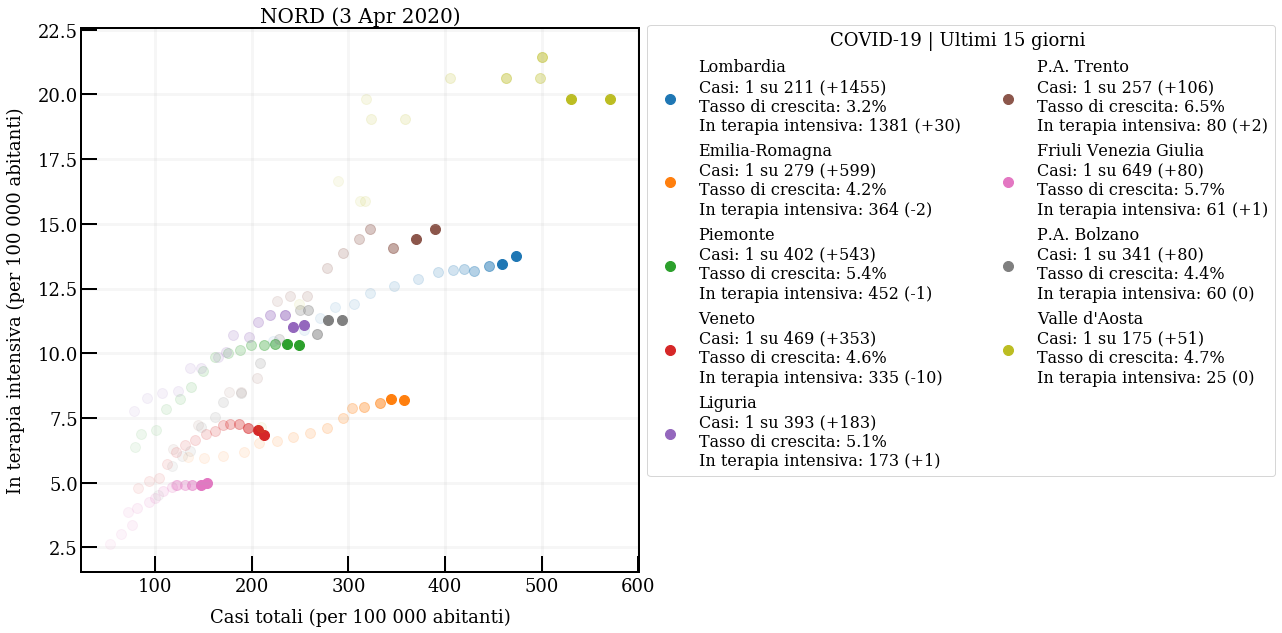

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


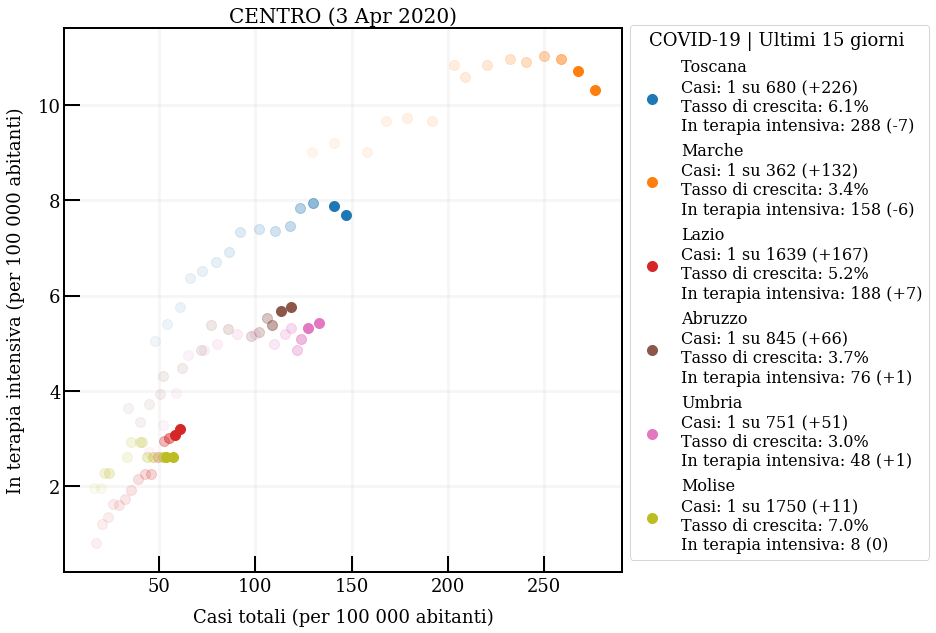

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


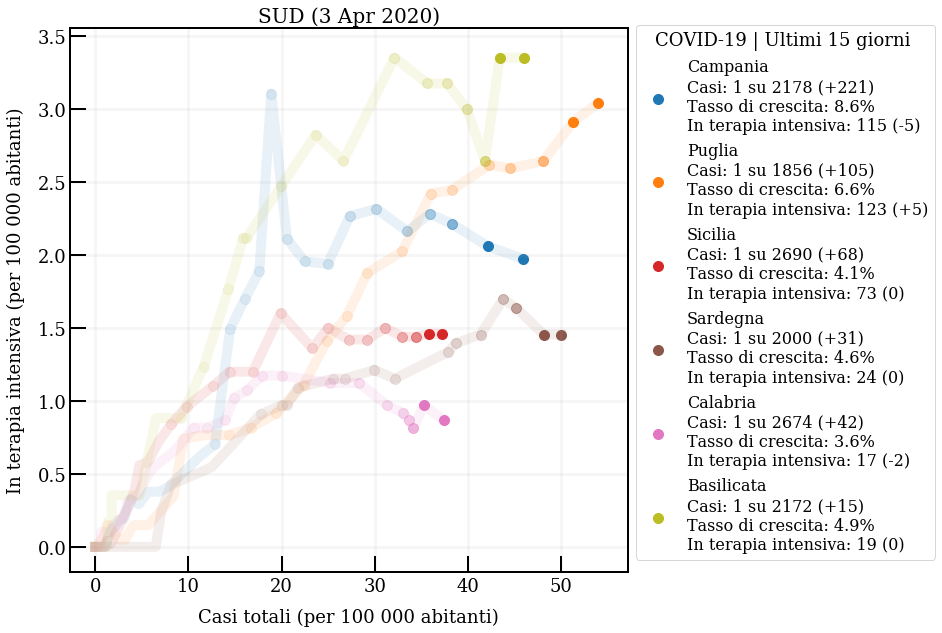

In [284]:
def pointevo_cases_icu(regions, dayspan, title='', line=False):
    vary = 'terapia_intensiva'
    varx = 'cases'
    regions = sorted_set(regions, 'cases')
    N = len(regions)
    cm = plt.get_cmap('tab10')

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # plot curves
    ndays = dayspan
    days = np.arange(1,ndays)
    mk = 'o'
    ms=100

    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df.population.iat[0]
        totx = df[varx].iat[-1]
        toty = df[vary].iat[-1]
        normalization = pop/1e5

        lb = '%s\nCasi: 1 su %.f (+%.f)' % (reg, pop/df.cases.iat[-1], df.new_cases.iat[-1])
        lb = lb + '\nTasso di crescita: %.1f%s' % (df.cases_delta3.iat[-1]*100, '%')
        sign = '+'
        if df.new_terapia_intensiva.iat[-1]<=0: sign=''
        lb = lb + '\nIn terapia intensiva: %d (%s%.f)' % (df.terapia_intensiva.iat[-1], sign, df.new_terapia_intensiva.iat[-1])
        if line:
            ax.plot(df[varx]/normalization, df[vary]/normalization, label='', color=cm(1.*i/N), lw=10, alpha=0.1)
        ax.scatter(df[varx].iat[-1]/normalization, df[vary].iat[-1]/normalization, label=lb, color=cm(1.*i/N), marker=mk, s=ms)

        for day in list(reversed(days)):
            x = df[varx].iat[-1-day]/normalization # total value 'day' ago
            y = df[vary].iat[-1-day]/normalization
            alpha = 1/day
            ax.scatter(x,y,label='', color=cm(1.*i/N), marker=mk, s=ms, alpha=alpha)

    plt.ylabel('In terapia intensiva (per 100 000 abitanti)')
    plt.xlabel('Casi totali (per 100 000 abitanti)')
    plt.grid(axis='x', linewidth=3, alpha=0.1, which='both')
    plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')
    
    #plt.text(0, ax.get_ylim()[1]*0.95, title, fontsize=24, horizontalalignment='left')
    #legend
    leg = plt.legend(loc='upper left', ncol=int(N/7)+1, bbox_to_anchor=(1.,1.02), 
                     title='COVID-19 | Ultimi %d giorni ' % ndays)
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20)

    plt.show()
    
    
regions = ['Lombardia', 'Emilia-Romagna', 'Marche', 'Piemonte', 'Veneto', 'Puglia', 'Lazio', 'Sicilia', 'Calabria', 'Campania']
pointevo_cases_icu(regions,15, 'Italia - 10 regioni', 0)
regions = nord
pointevo_cases_icu(regions,15, 'NORD', 0)
regions = centro
pointevo_cases_icu(regions,15, 'CENTRO', 0)
regions = sud
pointevo_cases_icu(regions,15, 'SUD', 1)